# Stack Traces Project

## Importing the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import re
from pathlib import Path
from typing import Tuple, List, Optional, Union
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
import string
import seaborn as sns
import datetime
from itertools import permutations
import heapq
import csv

# pd.options.display.max_colwidth = 999
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Setting up the project environment

In [3]:
# .csv configuration
encoding = "utf-8"
delimiter = None
working_directory_path = "./"

## Loading the question dataset

In [4]:
pure_data = working_directory_path + "question_tag.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [5]:
df.shape

(163194, 11)

## Answering the first research question (RQ1)

### Filtering the specific tags

In [6]:
def tag_filter(pref_tags: List, tags: str) -> bool:
    regex = ""
    for tag in pref_tags:
        regex += '(?=.*\\b'+ tag +'([+-]?([0-9]*[.])?[0-9]*)\\b)'
    regex = r"^" + regex + ".*$"
    tags = tags.strip().lower()
    match_result = re.match(regex, tags, re.MULTILINE | re.IGNORECASE)
    if match_result is None:
        return 0
    else:
        return 1

In [7]:
tags = ["tensorflow", "python"]
df['HasPreferableTags'] = df['Tags'].apply(lambda row_tags: tag_filter(tags, row_tags))

In [8]:
df_w_tags = df[df['HasPreferableTags']==True]

The new dataset that has a specific tag/s is reduced to:

In [9]:
print("The orginal DB: ", df.shape[0])
print("The new DB: ", df_w_tags.shape[0])
print("The difference is: ", df.shape[0] - df_w_tags.shape[0])

The orginal DB:  163194
The new DB:  61338
The difference is:  101856


In [10]:
df_w_tags = df_w_tags.drop(['HasPreferableTags'], axis='columns')

### Extracting the code parts from body

In [11]:
def extract_code_blocks(body: str) -> List:
    regex = r"<pre><code>((.*?)|(\n)*)*(<\/code><\/pre>|</pre></code>)"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result=[]
    
    try:
        for matchNum, match in enumerate(matches):
            code = match.group()
            code = code.replace("<pre><code>", "")
            code = code.replace("</pre></code>", "")
            code = code.replace("</code></pre>", "")
            result.append(code)
    except:
        print("\n Error(1): ")
        print(body)
        return None

    return result

In [12]:
df_w_tags['Code'] = df_w_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))

For testing:

In [13]:
# print(df_w_tags.iloc[7]['Body'])
# print(type(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(len(extract_code_blocks(df_w_tags.iloc[7]['Body'])))
# print(extract_code_blocks(df_w_tags.iloc[7]['Body'])[0])

Reset the index of dataframe:

In [14]:
df_w_tags = df_w_tags.reset_index(drop=True)

#### Finding the number of questions that have a code or not

In [15]:
coun_w_c = 0
coun_wo_c = 0

def counting_w_or_wo_code(row_code: List) -> bool:
    global coun_w_c
    global coun_wo_c
    
    if row_code:
        coun_w_c = coun_w_c + 1
        return True
    else:
        coun_wo_c = coun_wo_c + 1
        return False

In [16]:
df_w_tags['Has_code'] = df_w_tags['Code'].apply(lambda row_code: counting_w_or_wo_code(row_code))

### Extracting the text parts from body

In [17]:
def extract_text_blocks(i: int, body: str) -> Optional[List]:
    # It's bug
    if i in [10005, 14212, 21959, 26677, 53279]: 
        body = body + "</p>"

    regex = r"<p>((.*?)|(\n)*)*<\/p>"
    matches = re.finditer(regex, body, re.MULTILINE | re.IGNORECASE)
    result=[]

    try:
        for matchNum, match in enumerate(matches, start=1):
            text = match.group()
            text = text.replace("<p>", "")
            text = text.replace("</p>", "")
            result.append(text)
    except:
        print("\n Error(1): ")
        print(text)
        return None

    return result

In [18]:
df_w_tags['Text'] = df_w_tags.apply(lambda row: extract_text_blocks(row.name, row.Body), axis=1)

#### Finding the number of body words

In [19]:
def find_q_text_words(text_list: List) -> int:
    word_count = 0
    for text in text_list:
        word_count += sum([i.strip(string.punctuation).isalpha() for i in text.split()])
    return word_count

In [20]:
df_w_tags['Q_text_words_num'] = df_w_tags["Text"].apply(lambda text_list: find_q_text_words(text_list))

Save the dataframe as csv format

In [21]:
df_w_tags.to_csv('./amin_result_v1.csv', encoding='utf-8')

### Find the Regular Expressions for Unix and Windows base Pathnames

#### 1) Absolute and Relative Pathnames in UNIX OS

Stack/trace example: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed

Find the restrictions and limitations related to the Unix pathnames: https://www.cyberciti.biz/faq/linuxunix-rules-for-naming-file-and-directory-names/

Online regular expression environment for testing: https://regex101.com/r/ZyEx5u/4

> Regular Expression: "[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)"

#### 1) Pathnames in Windows OS

Stack/trace example: https://stackoverflow.com/questions/49434031/tensorflow-on-windows-cpu-version-importerror-no-module-named-pywrap-tensorf

Find the restrictions and limitations related to the Windows pathnames: <br /> 
https://docs.microsoft.com/en-us/dotnet/standard/io/file-path-formats <br />
https://docs.microsoft.com/en-us/windows/win32/fileio/naming-a-file

Online regular expression environment for testing: https://regex101.com/r/L6xmCa/1 , https://regex101.com/r/wz1WqW/1

> Regular Expression: "[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)"

In [22]:
def extract_pathnames_from_code_column(code_sec: List) -> Tuple[str, List]: 
    try:
        result_post_file_names = []
        OS_flag = None
        
        for code in code_sec:
            regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
            regex_windows = r"[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
            pattern_unix  = re.compile(regex_unix)
            pattern_windows  = re.compile(regex_windows)
            if pattern_unix.search(code):
                OS_flag = "unix"
                break
            elif pattern_windows.search(code):
                OS_flag = "windows"
                break
        
        if OS_flag == "unix":
            for code in code_sec:
                regex = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace("\\n", "\n")
                matches = re.finditer(regex, code, re.MULTILINE)
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[1].strip(), match.groups()[4].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 print(file_names_for_each_code_part)
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # Create a unique list
#                 print(file_names_for_each_code_part)
                
                if file_names_for_each_code_part:                                                   # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
                    
        elif OS_flag == "windows":
            for code in code_sec:
                regex = r"[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
                code = code.replace('&lt;', '<')
                code = code.replace('&gt;', '>')
                code = code.replace('&quot;', '"')
                matches = re.finditer(regex, code, re.MULTILINE)                            
                file_names_for_each_code_part = []

                for matchNum, match in enumerate(matches, start=1):
                    file_names_for_each_code_part.append((match.groups()[1].strip(), match.groups()[4].strip()))
#                     file_names_for_each_code_part.append(match.groups()[1].strip())
                    # print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
                    # for groupNum in range(0, len(match.groups())):
                        # groupNum = groupNum + 1
                        # print ("Group {groupNum} found at {start}-{end}: {group}".format(groupNum = groupNum, start = match.start(groupNum), end = match.end(groupNum), group = match.group(groupNum)))
#                 file_names_for_each_code_part = [s.strip() for s in file_names_for_each_code_part]  # Strip the list
#                 file_names_for_each_code_part = list(set(file_names_for_each_code_part))            # create a unique list
                if file_names_for_each_code_part:                                                   # Ignore the empty list
                    result_post_file_names.append(file_names_for_each_code_part)
            
    except:
        print("\n Error(2): \n", code_sec)
        return None, None

    return OS_flag, result_post_file_names

In [23]:
# Example for Unix path
# https://stackoverflow.com/questions/51839415/tensorflow-valueerror-rank-mismatch
# df_w_tags.iloc[9][:]
# df_w_tags['Code'] = df_w_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))
extract_pathnames_from_code_column(df_w_tags["Code"][9])

('unix',
 [[('estimator', 'train'),
   ('estimator', '_train_model'),
   ('estimator', '_train_model_default'),
   ('estimator', '_call_model_fn'),
   ('nn_ops', 'sparse_softmax_cross_entropy_with_logits')]])

In [24]:
# Example for Windows path
# df_w_tags['Code'] = df_w_tags['Body'].apply(lambda row_body: extract_code_blocks(row_body))
# print(df_w_tags["Code"][9])
# extract_pathnames_from_code_column(df_w_tags["Code"][84])
# extract_pathnames_from_code_column(df_w_tags["Code"][606])

In [25]:
# df_w_tags["Body"][606]

In [26]:
df_w_tags['Bugy_py_files'] = df_w_tags['Code'].apply(lambda row_code_ex: extract_pathnames_from_code_column(row_code_ex))

Save the dataframe as csv format

In [27]:
df_w_tags['Bugy_py_files'].to_csv('./amin_result_v2.csv', encoding='utf-8')

In [28]:
def create_has_trace_col(cal_tuple) -> bool:
    if cal_tuple[0] == "windows" or cal_tuple[0] == "unix":
        return True
    elif cal_tuple[0] is None:
        return False
    else:
        print("Error!")

In [29]:
df_w_tags['Has_trace'] = df_w_tags['Bugy_py_files'].apply(lambda cell_tuple: create_has_trace_col(cell_tuple))

#### Finding the number and type of LOC in the body of post:

For example how many pairs did you find in a post and defining the OS of that stack trace

In [30]:
def finding_line_of_code(code_list: List) -> Tuple[int, int, int]:
    line_count_trace_win   = 0
    line_count_trace_unix  = 0
    line_count_simple_code = 0
    
    for code in code_list:
        regex_unix    = r"[^\n\&\:\|\>\<\/\ \"\;\&]*(\/[^\n\&\:\|\>\<\/]+)+\/([^\n\&\:\|\>\<\/]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        regex_windows = r"[a-zA-Z]:\\?([^\<\>\:\"\\\/\/\|\?\*\n]+\\)+([^\<\>\:\"\\\/\/\|\?\*\n]+)(\.pyc|\.py)[^\d\n]+(\d+)\W*in\W*([a-zA-Z_$][a-zA-Z_$0-9]*)"
        pattern_unix  = re.compile(regex_unix)
        pattern_windows = re.compile(regex_windows)
        if pattern_unix.search(code):
            OS_flag = "unix"
        elif pattern_windows.search(code):
            OS_flag = "windows"
        else:
            OS_flag = "nothing"
            
        if OS_flag == "unix":
            line_count_trace_unix += len(code.splitlines())
        elif OS_flag == "windows":
            line_count_trace_win += len(code.splitlines())
        elif OS_flag == "nothing":
            line_count_simple_code += len(code.splitlines()) 
        else:
            print("Error!")

    return (line_count_trace_unix, line_count_trace_win, line_count_simple_code)

In [31]:
# finding_line_of_code(df_w_tags.loc[9, 'Code'])

In [32]:
df_w_tags['Line_code_u_w_s'] = df_w_tags['Code'].apply(lambda code_list: finding_line_of_code(code_list))

In [33]:
df_w_tags['Line_code_uix'] = df_w_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[0])

In [34]:
df_w_tags['Line_code_win'] = df_w_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[1])

In [35]:
df_w_tags['Line_code_simple_code'] = df_w_tags['Line_code_u_w_s'].apply(lambda loc_tuple: loc_tuple[2])

In [36]:
df_w_tags.head(10)

Id  PostTypeId  AcceptedAnswerId         CreationDate  ViewCount  AnswerCount  CommentCount  Score                                              Title                                               Body                                               Tags                                               Code  Has_code                                               Text  Q_text_words_num                                      Bugy_py_files  Has_trace Line_code_u_w_s  Line_code_uix  Line_code_win  Line_code_simple_code
0  43574928           1        43575038.0  2017-04-23 18:30:08       1118            1             0      3  How to use custom/non-default tf.Graph in Tens...  <p>I'm very new to <code>Tensorflow</code> and...  <python><session><graph><parallel-processing><...  [t = np.linspace(0,2*np.pi)\nfig, ax = plt.sub...      True  [I'm very new to <code>Tensorflow</code> and I...               108                                         (None, [])      False      (0, 0, 46)              0              0                     46
1  52019226           1        52019631.0  2018-08-25 16:32:19        312            1             2      0  Keras w/ Tensorflow intermediate layer extract...  <p>I am currently trying to leverage an interm...  <python><tensorflow><keras><deep-learning><bat...  [model = load_model('model.h5')\ninp = model.i...      True  [I am currently trying to leverage an intermed...                77                                         (None, [])      False      (0, 0, 28)              0              0                     28
2  48065685           1               NaN  2018-01-02 18:02:51        461            0             2      0          Issue with train.next_batch in Tensorflow  <p>I am currently facing an issue with the nex...  <python><python-3.x><tensorflow><machine-learn...  [AttributeError: 'str' object has no attribute...      True  [I am currently facing an issue with the next_...               102                                         (None, [])      False      (0, 0, 88)              0              0                     88
3  64070871           1               NaN  2020-09-25 20:19:10         45            0             1      1  How can i reshape TFRecord dataset to train RN...  <p>I am trying to feed an RNN model with <code...  <python><tensorflow><machine-learning><keras><...  [def get_dataset(directory, num_classes=60, ba...      True  [I am trying to feed an RNN model with <code>....                71                                         (None, [])      False      (0, 0, 48)              0              0                     48
4  45011900           1               NaN  2017-07-10 12:21:24       2936            0             7      3  Loading a trained model from Python to C++ in ...  <p>I'm looking to run a basic fully-connected ...                          <python><c++><tensorflow>                                                 []     False  [I'm looking to run a basic fully-connected ne...               161                                         (None, [])      False       (0, 0, 0)              0              0                      0
5  54004682           1        54005594.0  2019-01-02 10:27:49       1510            1             0      4                    Loading a video dataset (Keras)  <p>I'm trying to implement an LRCN/C(LSTM)RNN ...                 <python><tensorflow><video><keras>                                                 []     False  [I'm trying to implement an LRCN/C(LSTM)RNN to...                78                                         (None, [])      False       (0, 0, 0)              0              0                      0
6  60342600           1               NaN  2020-02-21 16:19:37         52            2             0      0  Difference between training accuracy and calcu...  <p>I have trained my neural network with a dat...               <python><tensorflow><neural-network>  [prelist=[]\nfor i in range(len(x)):\n    pred...      True  [I have trained my neural networ

#### Defining the lists for plotting the comparison of question length

In [37]:
list_num_words_w_tra  = []
list_num_words_wo_tra = []

for index1, row in df_w_tags.iterrows():
    if row.Has_trace is True:
        list_num_words_w_tra.append(row.Q_text_words_num)
    elif row.Has_trace is False:
        list_num_words_wo_tra.append(row.Q_text_words_num)
    else:
        print("Error!")

#### Defining the number of stack straces the belongs to the Unix or Windows OS

In [38]:
counter_win  = 0
counter_unix = 0
# dim_win  = []
# dim_unix = []

for tuple in df_w_tags["Bugy_py_files"]:
    if tuple[0] == "windows":
        counter_win += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_win.append(np_array.shape)
        
    elif tuple[0] == "unix":
        counter_unix += 1
#         np_array = np.array(tuple[1], dtype=object)
#         dim_unix.append(np_array.shape)

print(f"Table has {counter_win} windows labels.")
print(f"Table has {counter_unix} unix labels.")
# print("The dimensions of Windows labels is: ", set(dim_win))
# print("The dimensions of Unix labels is: ", set(dim_unix))

Table has 1732 windows labels.
Table has 3897 unix labels.


In [39]:
df_w_tags.dtypes

Id                         int64
PostTypeId                 int64
AcceptedAnswerId         float64
CreationDate              object
ViewCount                  int64
AnswerCount                int64
CommentCount               int64
Score                      int64
Title                     object
Body                      object
Tags                      object
Code                      object
Has_code                    bool
Text                      object
Q_text_words_num           int64
Bugy_py_files             object
Has_trace                   bool
Line_code_u_w_s           object
Line_code_uix              int64
Line_code_win              int64
Line_code_simple_code      int64
dtype: object

In [40]:
count_w_t  = 0
count_wo_t = 0
count_win  = 0
count_unix = 0

Question_with_trace_info = []
Question_with_wo_trace_info = []

def counting_w_or_wo_trace(row_id: int, 
                           row_cr: object, 
                           row_vc: int, 
                           row_ac: int, 
                           row_cc: int, 
                           row_sc: int, 
                           row_ac_an_id: float, 
                           row_t: object, 
                           has_code: bool) -> None:
    
    global count_w_t, count_wo_t, count_win, count_unix, Question_with_trace_info, Question_with_wo_trace_info

    if has_code:
        if row_t[0] is not None:
            count_w_t = count_w_t + 1
            Question_with_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))
            
            if row_t[0] == 'unix':
                count_unix = count_unix + 1
            else:
                count_win = count_win + 1
            
        else:
            count_wo_t = count_wo_t + 1
            Question_with_wo_trace_info.append((row_id, row_cr, row_vc, row_ac, row_cc, row_sc, row_ac_an_id))

        

In [41]:
df_w_tags.apply(lambda row: counting_w_or_wo_trace(row.Id, 
                                                   row.CreationDate, 
                                                   row.ViewCount,
                                                   row.AnswerCount,
                                                   row.CommentCount,
                                                   row.Score,
                                                   row.AcceptedAnswerId,
                                                   row.Bugy_py_files, 
                                                   row.Has_code), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
61333    None
61334    None
61335    None
61336    None
61337    None
Length: 61338, dtype: object

#### Creating a string matrix of pairs

https://stackoverflow.com/questions/32037893/numpy-fix-array-with-rows-of-different-lengths-by-filling-the-empty-elements-wi

In [42]:
def numpy_fillna(data: List) -> np.ndarray:
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(lens.max()) < lens[:, None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype='object')
    out[mask] = np.concatenate(data)
    
    return out

In [43]:
_2D_array = []

for row_tuple in df_w_tags['Bugy_py_files']:
    
    if row_tuple[0] is None: continue
    
    for element in row_tuple[1]:
        _2D_array.append(element)

# _2D_array_pad = numpy_fillna(_2D_array)

In [99]:
len(_2D_array)

5941

In [100]:
_2D_array[0]

[1, 2, 3, 4, 5]

#### Creating a numerical matrix

https://www.geeksforgeeks.org/python-pandas-factorize/

##### Creating a dictionary based on pairs and assigning a unique number to that

In [44]:
dic = {} 
specific_val = 1
for row in _2D_array:
    for element in row:
        if element not in dic:
            dic[element] = specific_val
            specific_val += 1

In [45]:
print("The number of unique pairs is: ", max(dic.values()))

The number of unique pairs is:  6392


##### Converting strings on the _2D_array into numbers 

In [47]:
for i, row in enumerate(_2D_array):
    for j in range(len(row)):
        _2D_array[i][j] = dic[_2D_array[i][j]]

In [101]:
_2D_array[0]

[1, 2, 3, 4, 5]

In [50]:
uniqe_dic = dict([(value, key) for key, value in dic.items()])

## Answering the second research question (RQ2): Finding Patterns

## Contiguous Sequential Pattern Mining

https://www.cc.gatech.edu/~hic/CS7616/pdf/lecture13.pdf

### Approach (1):

The shortest yet efficient implementation of the famous frequent sequential pattern mining algorithm PrefixSpan, the famous frequent closed sequential pattern mining algorithm BIDE (in closed.py), and the frequent generator sequential pattern mining algorithm FEAT (in generator.py), as a unified and holistic algorithm framework.

https://github.com/chuanconggao/PrefixSpan-py

### Approach (2): 

pymining is a small collection of data mining algorithms implemented in Python. I did not design any of the algorithms, but I use them in my own research so I thought other developers might be interested to use them as well.

https://github.com/bartdag/pymining

In [51]:
# !pip3 install -U prefixspan

In [52]:
from prefixspan import PrefixSpan

In [53]:
# ps = PrefixSpan(_2D_array_pad)

In [54]:
# k = ps.frequent(5)

In [55]:
# file = open("/home-students/amghad/sample.txt", "w")
# str_list = repr(k)
# file.write(str_list)
# file.close()

### Approach (3): 

In [56]:
def append_to_dicc_new(dicc, vec_id, list_):
    if vec_id not in dicc:
        # key not exist
        dicc[vec_id] = list_
    else:
        # key exist
        for tuple_ in list_:
            for item in dicc[vec_id]:
                if item[0] == tuple_[0]:
                    item[1].append(tuple_[1][0])
                    break
    return dicc

In [57]:
low = 10
up = len(uniqe_dic)
dicc = {}     

for i_v, vector in enumerate(_2D_array):    
    for index, element in enumerate(vector):
        list_ = []
        for wind_size in range(low, len(vector)+1-index):
            list_.append((wind_size, [(*vector[index:index+wind_size], )]))
        dicc = append_to_dicc_new(dicc, i_v, list_)    

In [58]:
def remove_duplication(dup_list):
    final_list = []
    for item in dup_list:
        if item not in final_list:
            final_list.append(item)
        else:
            indx = final_list.index(item)
            counter = final_list[indx][0] + 1
            pair = final_list[indx][1]
            final_list.remove(item)
            final_list.append((counter, pair))
    
    return final_list

In [59]:
dic_count = {}

for vec_i, list_tuples in dicc.items():
#     print(vec_i, list_tuples,"\n")
    for tuples_ in list_tuples:
#         print(tuples_)
        
        if tuples_[0] not in dic_count:
            lst_ = [(1, tuple_) for tuple_ in tuples_[1]] 
            
            if len(lst_) != len(set(lst_)):
                lst_ = remove_duplication(lst_)
            
            dic_count[tuples_[0]] = lst_  
        else:
            #(2, [(1, 3), (1, 4), (3, 4), (4, 5), (5, 1)]
            #break
            for tuple_ in tuples_[1]:
                flag = 0 
                for item in dic_count[tuples_[0]]:
                    if item[1] == tuple_:
                        counter = item[0] + 1
                        dic_count[tuples_[0]].remove(item)
                        dic_count[tuples_[0]].append((counter, item[1]))
                        flag = 1
                        break
                # tuple is new
                if flag == 0:
                    dic_count[tuples_[0]].append((1, tuple_))
#                 else: 
#                     print("Error100")

In [60]:
dic_count.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])

In [61]:
top_dic = {}

def get_top_patterns(dic_count, top):
    
    for win_size, list_tuples in dic_count.items():
        
        Set_ = {tuple_[0] for tuple_ in list_tuples}
        top_list = heapq.nlargest(top, Set_)
        
        top_dic[win_size] = []
        for item in list_tuples:
            if item[0] in top_list:
                top_dic[win_size].append(item)  

In [62]:
get_top_patterns(dic_count,1)

In [63]:
top_dic

{10: [(89, (310, 311, 312, 309, 313, 314, 315, 316, 317, 318))],
 11: [(88, (309, 310, 311, 312, 309, 313, 314, 315, 316, 317, 318))],
 12: [(74, (309, 310, 311, 312, 309, 313, 314, 315, 316, 317, 318, 320)),
  (74, (310, 311, 312, 309, 313, 314, 315, 316, 317, 318, 320, 321))],
 13: [(74, (309, 310, 311, 312, 309, 313, 314, 315, 316, 317, 318, 320, 321))],
 14: [(70,
   (470, 309, 310, 311, 312, 309, 313, 314, 315, 316, 317, 318, 320, 321))],
 15: [(61,
   (303,
    470,
    470,
    309,
    310,
    311,
    312,
    309,
    313,
    314,
    315,
    316,
    317,
    318,
    320)),
  (61,
   (470,
    470,
    309,
    310,
    311,
    312,
    309,
    313,
    314,
    315,
    316,
    317,
    318,
    320,
    321))],
 16: [(61,
   (303,
    470,
    470,
    309,
    310,
    311,
    312,
    309,
    313,
    314,
    315,
    316,
    317,
    318,
    320,
    321))],
 17: [(53,
   (302,
    303,
    470,
    470,
    309,
    310,
    311,
    312,
    309,
    313,


In [64]:
len(uniqe_dic)

6392

In [65]:
conv_dic = {}
for wind_size, pairs_list in top_dic.items():
    conv_dic[wind_size] = []
    for pair in pairs_list:
        t_tmp = ()
        for pair_element in pair[1]:
            i_to_str = uniqe_dic[pair_element]
            if not i_to_str:
                print("Error")
            t_tmp = t_tmp + (i_to_str,)
        conv_dic[wind_size].append((pair[0], t_tmp))

In [66]:
with open('dict.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in top_dic.items():
        writer.writerow([key, value])

In [67]:
[len(value) for key, value in dic_count.items()]

[8089,
 7419,
 6800,
 6228,
 5719,
 5272,
 4889,
 4533,
 4219,
 3942,
 3698,
 3467,
 3220,
 2999,
 2791,
 2604,
 2419,
 2262,
 2127,
 2005,
 1887,
 1779,
 1680,
 1585,
 1496,
 1412,
 1336,
 1264,
 1194,
 1132,
 1074,
 1024,
 978,
 937,
 897,
 859,
 825,
 793,
 764,
 737,
 713,
 689,
 667,
 645,
 624,
 604,
 586,
 569,
 553,
 537,
 521,
 505,
 490,
 475,
 460,
 445,
 430,
 415,
 400,
 387,
 374,
 362,
 350,
 340,
 330,
 320,
 311,
 302,
 294,
 286,
 278,
 270,
 262,
 254,
 246,
 238,
 230,
 222,
 214,
 206,
 198,
 190,
 182,
 175,
 168,
 161,
 154,
 147,
 140,
 133,
 127,
 122,
 117,
 112,
 107,
 102,
 98,
 94,
 91,
 88,
 85,
 82,
 79,
 76,
 73,
 70,
 67,
 64,
 61,
 58,
 55,
 53,
 51,
 49,
 47,
 45,
 43,
 41,
 39,
 37,
 35,
 33,
 31,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

In [68]:
dic_count.keys()

dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161])

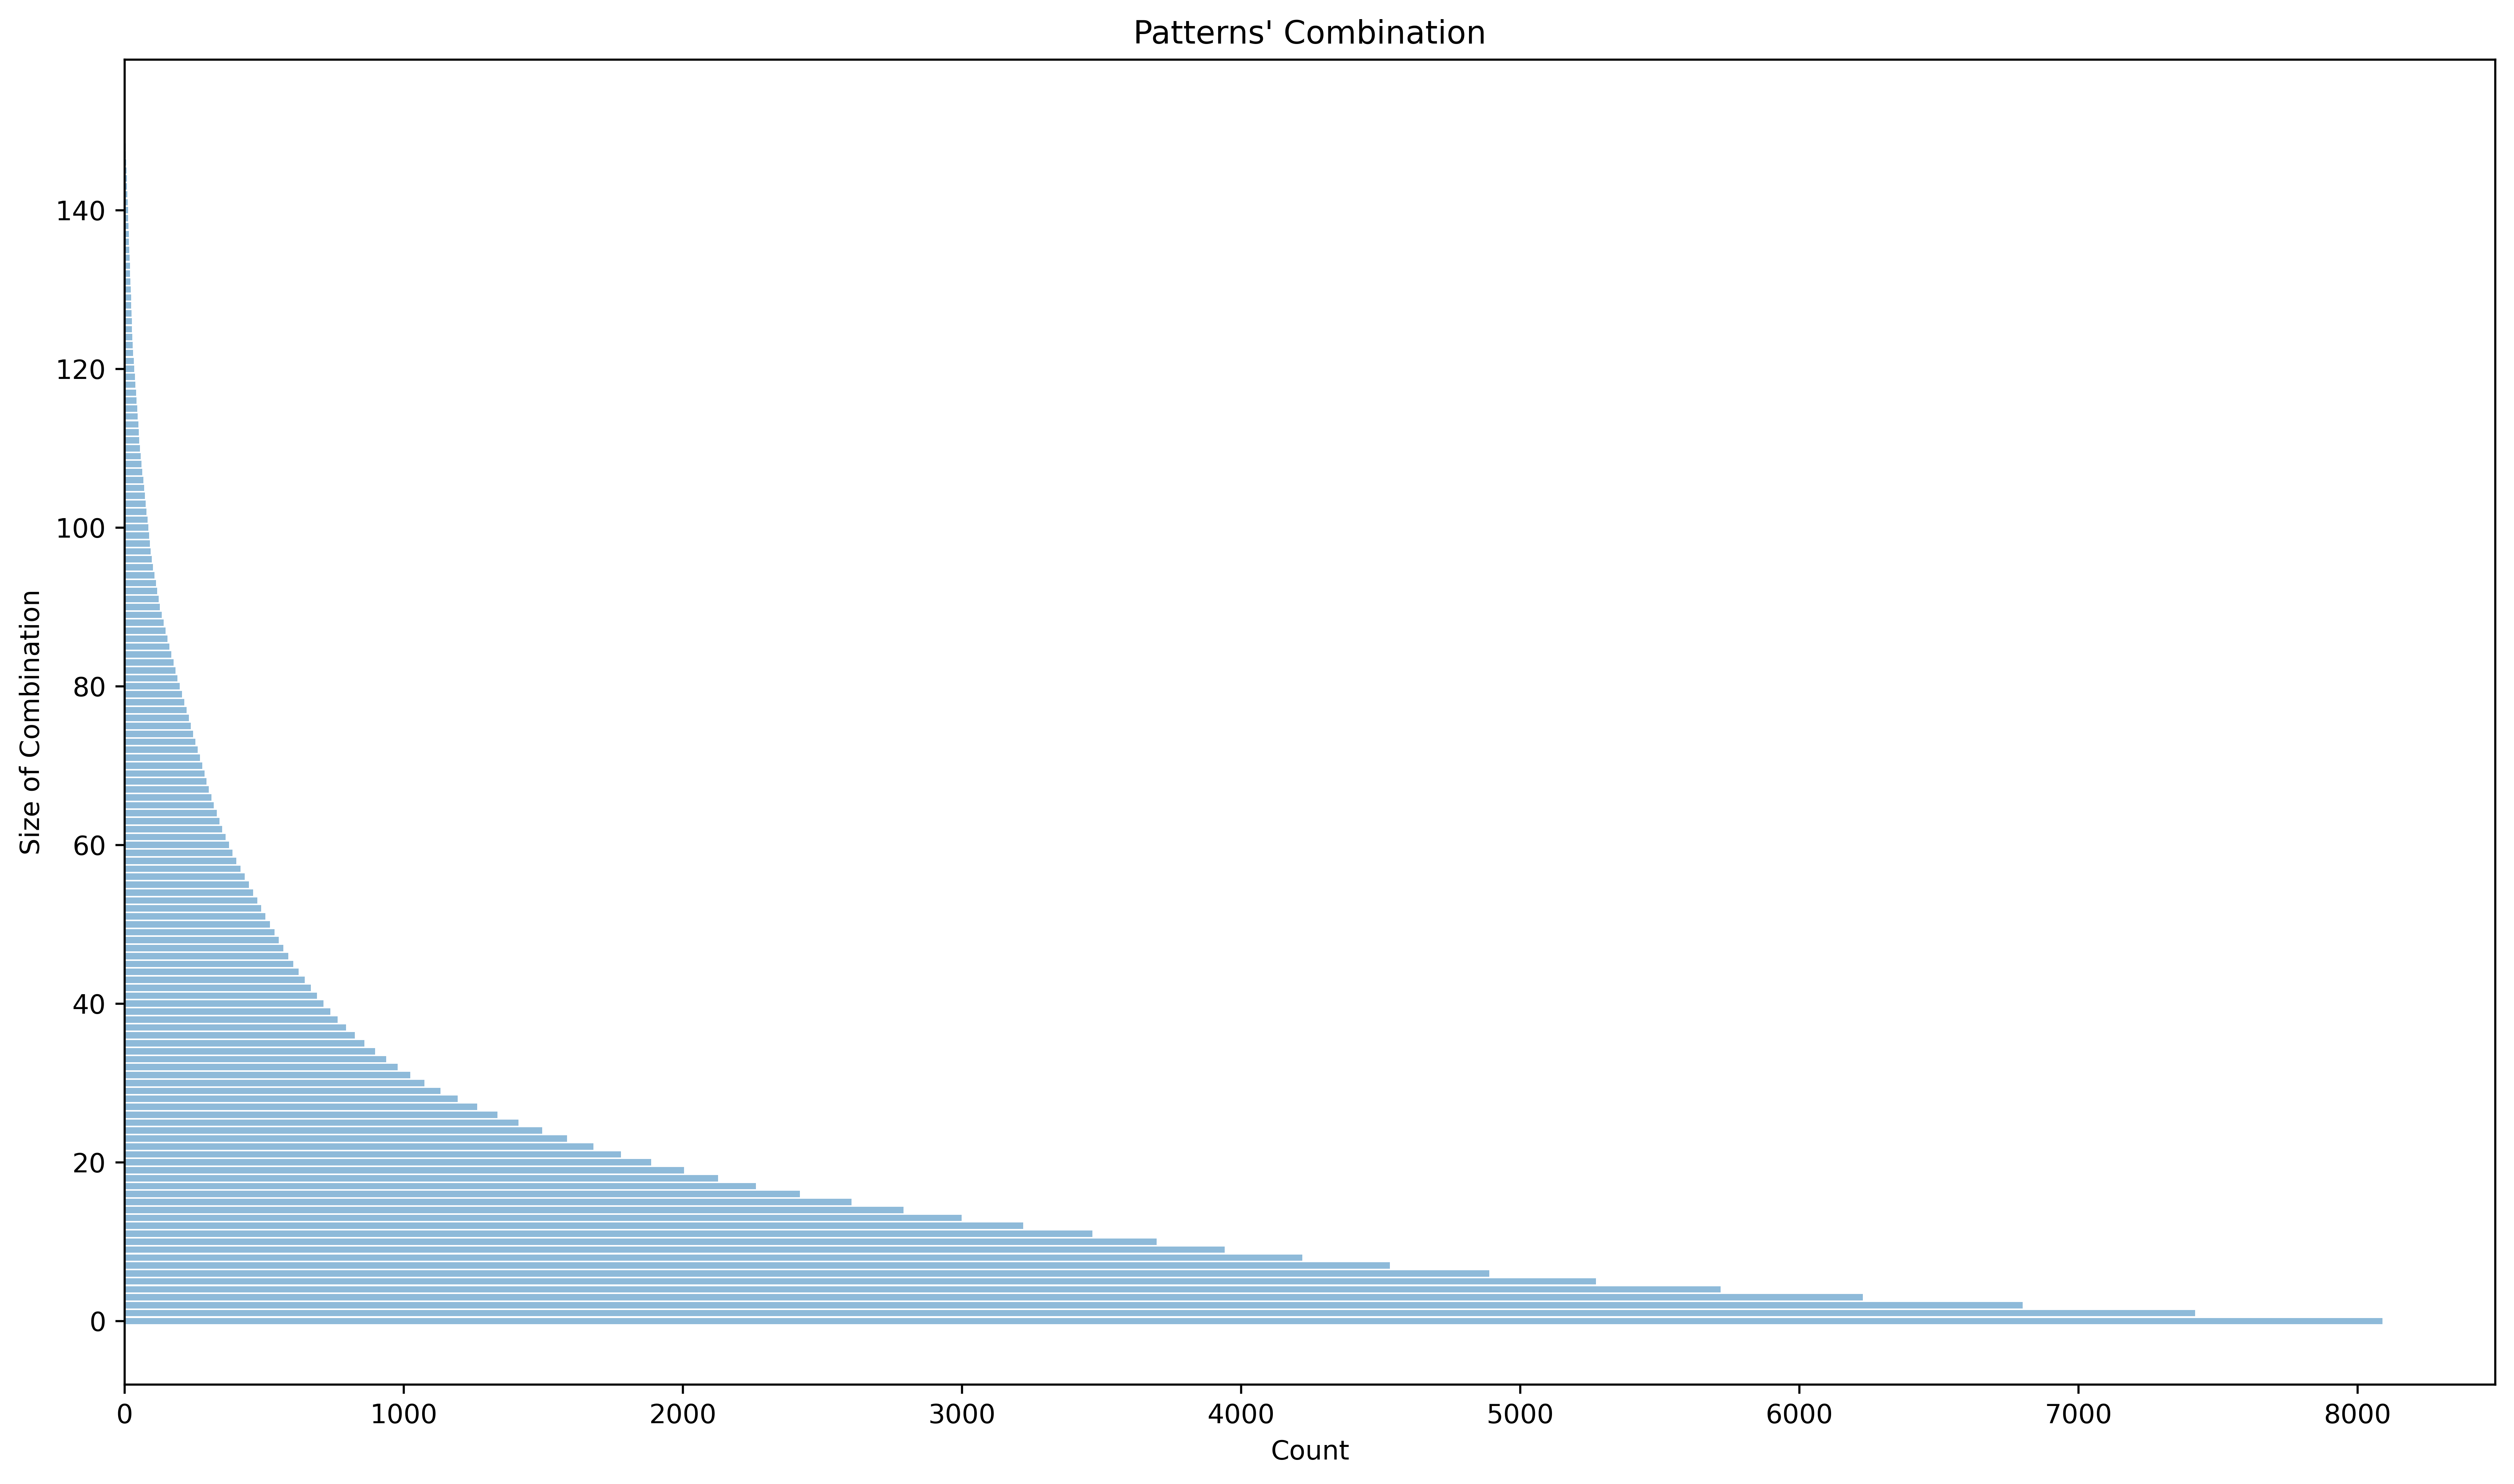

In [69]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = dic_count.keys()
y_pos = np.arange(len(objects))
performance = [len(value) for key, value in dic_count.items()]

fig, ax = plt.subplots(figsize =(16, 9), dpi=500)
ax.barh(y_pos, performance, align='center', alpha=0.5)

# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey')

# Add Plot Title
ax.set_title('Patterns\' Combination',loc ='center', )
# ax.set_yticks(y_pos, objects)
ax.set_xlabel('Count')
ax.set_ylabel('Size of Combination')

plt.show()

In [70]:
def append_to_dicc(dicc, indx_vec, pair_size, item):
    list_permut_tuples = dicc[indx_vec]
    flag = 0
    for tuple_per in list_permut_tuples:
        if tuple_per[0] == pair_size:
            flag = 1
            # check
            if item in set(tuple_per[1]):
                print("Error1")
            else:
#                 print("old")
                tuple_per[1].append(item)
            break
    if flag == 0:
#         arr = []
#         arr.append(item)
#         print("new")
        dicc[indx_vec].append((pair_size, item))
    return dicc 

In [71]:
def get_extended_permut(uniqe_dic, list_tuples):
    list_ = []
    for element in list_tuples:
        for key in uniqe_dic:
            list_.append((*element, key))
    return list_

In [72]:
def get_permut_from_dic(dicc, index_vec, pair_size):
    for tuple_item in dicc[index_vec]:
        if tuple_item[0] == pair_size:
            return tuple_item[1]
    return []

In [73]:
# low = 2
# up = len(uniqe_dic)
# dicc = {} 

# for m in range(low, up+1):
    
#     for i_v, vector in enumerate(_2D_array):
# #         print("\nvec ", vector)
#         list_ = []
#         flag = 0
#         if m == low:
#             permut_list = list(permutations(uniqe_dic.keys(), m))
#         else:
#             permut_pre = get_permut_from_dic(dicc, i_v, m-1)
#             if not permut_pre:
#                 # There is no pairs for the previous combination
# #                 print("\n\nsalam\n\n", m)
#                 continue
#             permut_list = get_extended_permut(uniqe_dic , permut_pre)
        
# #         print("Per list: ", permut_list)
# #         print("Dicc curent: ", dicc)
        
#         for pair in permut_list:
# #             print(pair)
#             for idx, element_str in enumerate(vector):   
#                 if element_str == pair[0]:
#                     if (idx+len(pair)) <= len(vector): 
#                         for i_p in range(0, len(pair)):
#                             if pair[i_p] != vector[idx+i_p]:
#                                 flag = 1
#                                 break
#                         if flag == 0:
#                             list_.append(pair)
#                         flag = 0
#         # insert to dic
#         if m == low:
#             dicc[i_v] = [(len(pair), list_)]
#         else:
#             # List not empty
#             if list_:
#                 #print("sa ", list_)
#                 dicc = append_to_dicc(dicc, i_v, len(pair), list_)
#             #print(dicc)

# #         print(dicc)
# #     if m == low+1:
# #         break

In [74]:
#_2D_array_pad = numpy_fillna(_2D_array)

In [75]:
#_2D_array_pad.shape

In [76]:
# print(f"The number of entire stack traces is {_2D_array_pad.shape[0]} and the maximum number of pairs in a stack trase is {_2D_array_pad.shape[1]}.")

## Answering the third research question (RQ3): Answer time

### Loading Answer Dataset

In [77]:
# pure_ans_data = working_directory_path + "ansSample.csv"
# path_ans = Path(pure_ans_data)

# if path_ans.suffix == ".csv":
#     df_ans = pd.read_csv(path_ans, encoding=encoding)
# else:
#     raise ValueError("{data_file_path.suffix} extensions are not supported")

## Create DF based on the questions contain stack traces

In [78]:
df_status_w_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

In [79]:
df_status_w_stack["Q_info"] = Question_with_trace_info

In [80]:
Question_with_trace_info[0]

(51839415, '2018-08-14 10:35:10', 383, 1, 5, 0, nan)

In [81]:
df_status_w_stack["Q_id"]          = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_w_stack["Q_create_time"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_w_stack["View_count"]    = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_w_stack["Answer_count"]  = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_w_stack["Comment_count"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_w_stack["Score"]         = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_w_stack["Accepted_Answer_id"] = df_status_w_stack['Q_info'].apply(lambda q_info: q_info[6])

In [82]:
df_status_w_stack = df_status_w_stack.drop(['Q_info'], axis='columns')

In [83]:
df_status_w_stack["Q_create_time"]      = pd.to_datetime(df_status_w_stack["Q_create_time"])
df_status_w_stack["First_acc_ans_time"] = pd.to_datetime(df_status_w_stack["First_acc_ans_time"])
df_status_w_stack["First_ans_time"]     = pd.to_datetime(df_status_w_stack["First_ans_time"])

#### Filling the Answers column: A list contains the id and time of answers

In [84]:
pure_data = working_directory_path + "nightnight.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [85]:
df_status_w_stack['Answers'] = df_status_w_stack.apply(lambda x: [], axis=1)

In [86]:
for index1, row_status in df_status_w_stack.iterrows():
    for index2, row_night in df_night.iterrows():
            if row_night["ParentId"] == row_status["Q_id"]:
                    row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [87]:
df_status_w_stack["Answers"] = df_status_w_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [88]:
def checker_1(i, answers_list, answers_count):
    global counter
    if len(answers_list) != answers_count:
        print("Error ", i, len(answers_list), answers_count)

In [89]:
df_status_w_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
5624    None
5625    None
5626    None
5627    None
5628    None
Length: 5629, dtype: object

In [90]:
df_status_w_stack

First_ans_time First_acc_ans_time                            Answers      Q_id       Q_create_time  View_count  Answer_count  Comment_count  Score  Accepted_Answer_id
0               NaT                NaT  [(51862965, 2018-08-15 16:46:25)]  51839415 2018-08-14 10:35:10         383             1              5      0                 NaN
1               NaT                NaT  [(59636620, 2020-01-07 21:55:52)]  59632120 2020-01-07 16:13:19         654             1              0      1                 NaN
2               NaT                NaT                                 []  64347099 2020-10-14 05:23:03          47             0              4      0                 NaN
3               NaT                NaT  [(38996589, 2016-08-17 12:24:19)]  38996464 2016-08-17 12:18:26         343             1              0      0          38996589.0
4               NaT                NaT                                 []  65145865 2020-12-04 15:01:56          25             0              3     -1                 NaN
...             ...                ...                                ...       ...                 ...         ...           ...            ...    ...                 ...
5624            NaT                NaT  [(63311448, 2020-08-08 03:10:20)]  63309153 2020-08-07 21:07:36         734             1              1      0                 NaN
5625            NaT                NaT  [(59316154, 2019-12-13 04:30:29)]  59316054 2019-12-13 04:15:35         221             1              0      1                 NaN
5626            NaT                NaT                                 []  54960120 2019-03-02 15:32:02         867             0              3      0                 NaN
5627            NaT                NaT                                 []  55883985 2019-04-27 19:11:26         870             0             12      0                 NaN
5628            NaT                NaT  [(60826314, 2020-03-24 07:06:23)]  60535969 2020-03-04 23:01:36         359             1              0      1                 NaN

[5629 rows x 10 columns]

In [91]:
for index1, row_status in df_status_w_stack.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answers"]:
        # print("is empty")
        continue

    for answer in row_status["Answers"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    df_status_w_stack.at[index1,'First_ans_time'] = fr_time
    df_status_w_stack.at[index1,'First_acc_ans_time'] = acc_time

In [92]:
df_status_w_stack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5629 entries, 0 to 5628
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   First_ans_time      3784 non-null   datetime64[ns]
 1   First_acc_ans_time  3784 non-null   datetime64[ns]
 2   Answers             5629 non-null   object        
 3   Q_id                5629 non-null   int64         
 4   Q_create_time       5629 non-null   datetime64[ns]
 5   View_count          5629 non-null   int64         
 6   Answer_count        5629 non-null   int64         
 7   Comment_count       5629 non-null   int64         
 8   Score               5629 non-null   int64         
 9   Accepted_Answer_id  1892 non-null   float64       
dtypes: datetime64[ns](3), float64(1), int64(5), object(1)
memory usage: 439.9+ KB


Write df_status_w_stack to the CSV file:

In [93]:
df_status_w_stack.to_csv('./status_df_w_stack_with_list_of_answers_col.csv', encoding='utf-8')

Read df_status_w_stack from the CSV file:

In [94]:
df_status_w_stack = pd.read_csv('./status_df_w_stack_with_list_of_answers_col.csv', encoding=encoding)

In [95]:
df_status_w_stack["Duration_ans"] = df_status_w_stack.apply(lambda row: (row.First_ans_time-row.Q_create_time).days, axis=1)
df_status_w_stack["Duration_acc_ans"] = df_status_w_stack.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).days, axis=1)


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
df_status_w_stack['Duration_ans'] = df_status_w_stack['Duration_ans'].fillna(0)
df_status_w_stack['Duration_acc_ans'] = df_status_w_stack['Duration_acc_ans'].fillna(0)

In [ ]:
df_status_w_stack.head()

In [ ]:
df_status_w_stack.info()

In [ ]:
df_status_w_stack.shape

In [ ]:
df_status_w_stack.describe()

## Create DF based on the questions do not have stack traces

In [ ]:
pure_data = working_directory_path + "night_wo.csv"
path = Path(pure_data)

if path.suffix == ".csv":
    df_night_wo = pd.read_csv(path, encoding=encoding)
else:
    raise ValueError("{data_file_path.suffix} extensions are not supported")

In [ ]:
df_status_wo_stack = pd.DataFrame(columns=['First_ans_time', 'First_acc_ans_time', 'Answers'])

df_status_wo_stack["Q_info"] = Question_with_wo_trace_info

df_status_wo_stack["Q_id"]          = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[0])
df_status_wo_stack["Q_create_time"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[1])
df_status_wo_stack["View_count"]    = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[2])
df_status_wo_stack["Answer_count"]  = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[3])
df_status_wo_stack["Comment_count"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[4])
df_status_wo_stack["Score"]         = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[5])
df_status_wo_stack["Accepted_Answer_id"] = df_status_wo_stack['Q_info'].apply(lambda q_info: q_info[6])

df_status_wo_stack = df_status_wo_stack.drop(['Q_info'], axis='columns')

df_status_wo_stack["Q_create_time"] = pd.to_datetime(df_status_wo_stack["Q_create_time"])
df_status_wo_stack["First_acc_ans_time"] = pd.to_datetime(df_status_wo_stack["First_acc_ans_time"])
df_status_wo_stack["First_ans_time"]     = pd.to_datetime(df_status_wo_stack["First_ans_time"])

In [ ]:
df_night_wo.head()

In [ ]:
df_status_wo_stack.head()

In [ ]:
df_status_wo_stack['Answers'] = df_status_wo_stack.apply(lambda x: [], axis=1)

In [ ]:
for index2, row_night in df_night_wo.iterrows():
    for index1, row_status in df_status_wo_stack.iterrows():
            if row_night["ParentId"] == row_status["Q_id"]:
                    row_status['Answers'].append((row_night["Id"], row_night["CreationDate"]))

In [ ]:
df_status_wo_stack["Answers"] = df_status_wo_stack["Answers"].apply(lambda answers_list: list(set(answers_list)))

In [ ]:
df_status_wo_stack.apply(lambda row: checker_1(row.name, row.Answers, row.Answer_count), axis=1)

In [ ]:
for index1, row_status in df_status_wo_stack.iterrows():   
    flag = 0
    fr_time = pd.to_datetime(datetime.datetime.now())
    acc_time = pd.to_datetime(datetime.datetime.now())
        
    if not row_status["Answers"]:
        # print("is empty")
        continue

    for answer in row_status["Answers"]:
        
        anwer_time = pd.to_datetime(answer[1])
        
        if flag == 0:
            fr_time = anwer_time
            flag = 1
        
        if fr_time > anwer_time:
            fr_time = anwer_time
        
        if row_status["Accepted_Answer_id"] == answer[0]:
            acc_time = anwer_time

    df_status_wo_stack.at[index1,'First_ans_time'] = fr_time
    df_status_wo_stack.at[index1,'First_acc_ans_time'] = acc_time

In [ ]:
df_status_wo_stack["Duration_ans"] = df_status_wo_stack.apply(lambda row: (row.First_ans_time-row.Q_create_time).days, axis=1)
df_status_wo_stack["Duration_acc_ans"] = df_status_wo_stack.apply(lambda row: (row.First_acc_ans_time-row.Q_create_time).days, axis=1)


In [ ]:
df_status_w_stack['Duration_ans'] = df_status_w_stack['Duration_ans'].fillna(0)
df_status_w_stack['Duration_acc_ans'] = df_status_w_stack['Duration_acc_ans'].fillna(0)

In [ ]:
df_status_wo_stack.to_csv('./wo_otagh_toolani.csv', encoding='utf-8')

### Find the durarion of answers amongst questions contian stack traces

In [ ]:
df_status_w_stack

In [ ]:
df_1 = pd.DataFrame(columns=['Questions (with stack traces)', 'Days'])
df_1['Days'] = df_status_w_stack['Duration_ans']
df_1['Questions (with stack traces)'] = df_1['Questions (with stack traces)'].apply(lambda x: "First Answer")

df_2 = pd.DataFrame(columns=['Questions (with stack traces)', 'Days'])
df_2['Days'] = df_status_w_stack['Duration_acc_ans']
df_2['Questions (with stack traces)'] = df_2['Questions (with stack traces)'].apply(lambda x: "First Accepted Answer")

result = pd.concat([df_1, df_2])

fig = plt.figure(figsize=(10, 5), dpi=300)

sns.violinplot(x=result["Questions (with stack traces)"], y=result["Days"])

plt.ylim(-250,500)

# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# # min_ = min(min(df_status_w_stack['Duration_ans']), min(df_status_w_stack['Duration_acc_ans']))
# # max_ = max(max(df_status_w_stack['Duration_ans']), max(df_status_w_stack['Duration_acc_ans']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['Duration_ans'])
# ax1.set_xlabel("First Answer")
# ax1.set_ylabel("Day")
# # ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_w_stack['Duration_acc_ans'])
# ax2.set_xlabel("First Accepted Answer")
# ax2.set_ylabel("Day")
# # ax2 = plt.ylim(min_,max_)

fig.suptitle('Answers Duration (with stack traces)')

fig.tight_layout()
plt.show()

## Statistics Information

In [ ]:
print("Question Numbers with all ML tags: ", df.shape[0])

In [ ]:
print("Question Numbers (with Tensorflow tags): ", df_w_tags.shape[0])

In [ ]:
print("Question Numbers (without Tensorflow tags): ", df.shape[0] - df_w_tags.shape[0])

In [ ]:
print("Tensorflow Question Numbers (with code): ", coun_w_c)
print("Tensorflow Question Numbers (without code): ", coun_wo_c)

In [ ]:
print("Tensorflow Question Numbers (with code) have stack trace: ", count_w_t)
print("Tensorflow Question Numbers (with code) that doesn't have stack trace: ",count_wo_t-27)

In [ ]:
print("Tensorflow Question Numbers (with stack trace:) on Unix based systems: ", count_unix)
print("Tensorflow Question Numbers (with stack trace:) on Windows based systems: ", count_win)

In [ ]:
line_count_unix   = 0
line_count_win    = 0
line_count_simple = 0

for tuple in df_w_tags["Line_code_u_w_s"]:
    line_count_unix   += tuple[0]
    line_count_win    += tuple[1]
    line_count_simple += tuple[2]
        
print(f"The total number of line codes in the body part (w/o stack trace) is {line_count_simple}.")
print(f"The total LOC amongst stack traces is {line_count_unix} (Unix-based reports).")
print(f"The total LOC amongst stack traces is {line_count_win} (Windows-based reports).")
print(f"The total LOC amongst stack traces is {line_count_unix+line_count_win}.")

In [ ]:
print(f"We found {max(dic.values())} unique pairs in stack traces posts related to the Tensorflow frameworks.")

## Graphical Results

### LOC

In [ ]:
code_wo_trace = df_w_tags["Line_code_simple_code"]
code_w_trace_w = df_w_tags["Line_code_win"]
code_w_trace_u = df_w_tags["Line_code_uix"]
code_w_trace = df_w_tags["Line_code_win"] + df_w_tags["Line_code_uix"]

df_1 = pd.DataFrame(columns=['Questions', 'LOC (in each question post)'])
df_1['LOC (in each question post)'] = code_wo_trace
df_1['Questions'] = df_1['Questions'].apply(lambda x: "Code W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Questions', 'LOC (in each question post)'])
df_2['LOC (in each question post)'] = code_w_trace
df_2['Questions'] = df_2['Questions'].apply(lambda x: "Code With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="LOC (in each question post)", 
               data=result, 
               hue="Questions", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-15, 100)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the LOC between regular code and stack trace')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Question Length

In [ ]:
df_1 = pd.DataFrame(columns=['Question Length', 'Words (in each question post)'])
df_1['Words (in each question post)'] = list_num_words_wo_tra
df_1['Question Length'] = df_1['Question Length'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Length', 'Words (in each question post)'])
df_2['Words (in each question post)'] = list_num_words_w_tra
df_2['Question Length'] = df_2['Question Length'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(4, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Words (in each question post)", 
               data=result, 
               hue="Question Length", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(0, 300)
# plt.xlim(-1, 1)

fig.suptitle('Comparing the Question Length')

plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":8})
fig.tight_layout()

plt.show()

### Plotting Score, View, Answer, Comment Counts 

In [ ]:
def get_sturges_rule_number(n_obser: int) -> int:
    '''
    Sturges’ Rule is the most common method for determining the optimal number of bins.

    Parameters:
    ----------
    n_obser : int
        The total number of observations in the dataset.

    Returns:
    ----------
    Use ⌈ ⌉ for returning a value: Symbols that mean “ceiling” – i.e. round the answer up to
    the nearest integer.
    '''
    # return round(1 + math.log2(n_obser))
    return round(np.ceil(1 + (3.322 * np.log10(n_obser))))

In [ ]:
plt.figure(figsize=[25,15])
plt.subplot(211)

plt.title('View Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['View_count']))

n, bins, patches = plt.hist(df_status_w_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(False)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)


plt.subplot(212)

plt.title('View Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nView Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['View_count']))

n, bins, patches = plt.hist(df_status_wo_stack['View_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='purple', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=15)

plt.tight_layout(pad=4.0)
plt.show()

In [ ]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['View_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['View_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.7)

plt.ylim(-2500,13000)
# plt.xlim(-1,1)

fig.suptitle('View Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Answer Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_w_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Answer Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nAnswer Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Answer_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Answer_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='g', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

In [ ]:
sns.set_theme(style="whitegrid")
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-.5,4.1)
# plt.xlim(-1,1)

fig.suptitle('Answer Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

In [ ]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Comment Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_w_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Comment Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nComment Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Comment_count']))

n, bins, patches = plt.hist(df_status_wo_stack['Comment_count'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='b', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)

plt.show()

In [ ]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1.1,10)
# plt.xlim(-1,1)

fig.suptitle('Comment Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})

plt.show()

In [ ]:
# Example:

sns.set_theme(style="whitegrid")
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Comment_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Comment_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultComment = pd.concat([df_1, df_2])
resultComment['Type'] = "Comment Count"
# ###################################################################################
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Answer_count']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Answer_count']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

resultAnswer = pd.concat([df_1, df_2])
resultAnswer['Type'] = "Answer Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['View_count']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['View_count']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultView = pd.concat([df_1, df_2])
# resultView['Type'] = "View Count"
# ###################################################################################
# df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_1['Frequency'] = df_status_wo_stack['Score']
# df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

# df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
# df_2['Frequency'] = df_status_w_stack['Score']
# df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

# resultScore = pd.concat([df_1, df_2])
# resultScore['Type'] = "Score Count"
# ###################################################################################
result = pd.concat([resultComment, resultAnswer], ignore_index=True)

fig = plt.figure(figsize=(10, 5), dpi=300)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-1,6)
# plt.xlim(-1,1)

fig.suptitle('TensorFlow Questions', prop={"size":10})
# plt.gca().axes.get_xaxis().set_visible(False)
# plt.legend(loc='upper left')

plt.show()

In [ ]:
plt.figure(figsize=[25,15])

plt.subplot(211)

plt.title('Score Count (With Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_w_stack['Score']))

n, bins, patches = plt.hist(df_status_w_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.subplot(212)

plt.title('Score Count (W/O Stack Traces)', fontsize=25)
plt.xlabel('\nScore Range', fontsize=20)
plt.ylabel('Frequency', fontsize=20)

n_bins = get_sturges_rule_number(len(df_status_wo_stack['Score']))

n, bins, patches = plt.hist(df_status_wo_stack['Score'], 
                             bins=n_bins, 
                             log=True, 
                             align='right', 
                             color='orange', 
                             edgecolor='black')

# define minor ticks and draw a grid with them
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
# plt.grid(which='minor', color='white', lw = 0.5)
# x ticks
xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
dist = (xticks[1] - xticks[0])/2
xticks = [e+dist for e in xticks]
xticks_labels = [ "{:.1f}\nto\n{:.1f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
plt.xticks(xticks, labels = xticks_labels, fontsize=18)

plt.tight_layout(pad=4.0)
plt.show()

In [ ]:
df_1 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_1['Frequency'] = df_status_wo_stack['Score']
df_1['Question Type'] = df_1['Question Type'].apply(lambda x: "W/O Stack Traces")

df_2 = pd.DataFrame(columns=['Question Type', 'Frequency'])
df_2['Frequency'] = df_status_w_stack['Score']
df_2['Question Type'] = df_2['Question Type'].apply(lambda x: "With Stack Traces")

result = pd.concat([df_1, df_2])
result['Type'] = "Question Type"

fig = plt.figure(figsize=(5, 5), dpi=100)

sns.violinplot(x="Type", 
               y="Frequency", 
               data=result, 
               hue="Question Type", 
               palette="Set2", #colorblind
               split=True, 
               scale="count",
               inner="quartile",
               scale_hue=False,
               width=.5)

plt.ylim(-7,15)
# plt.xlim(-1,1)

fig.suptitle('Score Count')
plt.gca().axes.get_xaxis().set_visible(False)
# plt.plot(legend=None)
plt.legend(loc='upper right', prop={"size":10})
fig.tight_layout()
plt.show()



In [ ]:
# facecolor = '#EAEAEA'
# color_bars = '#3475D0'
# txt_color1 = '#252525'
# txt_color2 = '#004C74'
# fig, ax = plt.subplots(1, figsize=(20,6), facecolor=facecolor)
# ax.set_facecolor(facecolor)
# n, bins, patches = plt.hist(df_status_w_stack['Score'], 
#                              bins=n_bins, color=color_bars, log=True)
# #grid
# minor_locator = AutoMinorLocator(2)
# plt.gca().xaxis.set_minor_locator(minor_locator)
# # plt.grid(which='minor', color=facecolor, lw = 0.5)
# xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
# xticks_labels = [ "{:.0f}-{:.0f}".format(value, bins[idx+1]) for idx, value in enumerate(bins[:-1])]
# plt.xticks(xticks, labels=xticks_labels, c=txt_color1, fontsize=13)

# # remove major and minor ticks from the x axis, but keep the labels
# ax.tick_params(axis='x', which='both',length=0)
# # remove y ticks
# plt.yticks([])

# # Hide the right and top spines
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# for idx, value in enumerate(n):
#     if value > 0:
#         plt.text(xticks[idx], value+5, int(value), ha='center', fontsize=16, c=txt_color1)

# plt.title('\nTensorFlow - Score Count\n', loc = 'center', fontsize = 20, c=txt_color1)
# plt.xlabel('\nScore Range', c=txt_color2, fontsize=14)
# plt.ylabel('\nFrequency', c=txt_color2, fontsize=14)
# plt.tight_layout()
# # plt.savefig('costs.png', facecolor=facecolor)

In [ ]:
# import datetime

# flag = 0
# fr_time = pd.to_datetime(datetime.datetime.now())
# acc_time = pd.to_datetime(datetime.datetime.now())

# for answer in tt:
#     anwer_time = pd.to_datetime(answer[1])
#     if flag == 0:
#         fr_time = anwer_time
#         flag = 1
    
#     if fr_time > anwer_time:
#         fr_time = anwer_time
    
#     if int(60535969) == answer[0]:
#         acc_time = anwer_time

# print(fr_time)
# print(acc_time)

In [ ]:
# fig = plt.figure(figsize=(10, 5))
# gs = fig.add_gridspec(1, 2)

# min_ = min(min(df_status_w_stack['View_count']), min(df_status_wo_stack['View_count']))
# max_ = max(max(df_status_w_stack['View_count']), max(df_status_wo_stack['View_count']))

# ax1 = fig.add_subplot(gs[0, 0])
# sns.violinplot(data=df_status_w_stack['View_count'])
# ax1.set_xlabel("with Stack Traces")
# ax1.set_ylabel("Frequency")
# ax1 = plt.ylim(min_,max_)

# ax2 = fig.add_subplot(gs[0, 1])
# sns.violinplot(data=df_status_wo_stack['View_count'])
# ax2.set_xlabel("w/o Stack Traces")
# ax2.set_ylabel("Frequency")
# ax2 = plt.ylim(min_,max_)